In [1]:
from libraries import lib
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from libraries.NeuralStates import *

In [ ]:
# import numpy.random as npr
# import random

# class SparseStateVector:
#     """
#     Container class for dictionary (self.values) with keys of integer states
#     and values being complex amplitude of psi
#     """
#     def __init__(self):
#         self.values = {}
#         self.normalized = False

#     def TFIM_multiply(psi, N, J, Gamma):
#         """
#         Returns new sparse vector representing H|psi>
#         """
#         prod = SparseStateVector()
#         for state in psi.values:
#             jtotal = 0
#             for site in range(N - 1):
#                 jtotal += J if ((state >> site) ^ (state >> site + 1)) & 1 else -J
#             jtotal += J if ((state >> (N - 1)) ^ (state >> 0)) & 1 else -J 
#             prod.values[state] = jtotal * psi.values[state]
        
#         for state in psi.values:
#             for site in range(N):
#                 flipped_state = state ^ (1 << site)
#                 prod.values[flipped_state] = prod.values.get(flipped_state, 0) - Gamma * psi.values[state]
#         return prod

#     def inner_product(v1, v2):
#         """
#         Returns <v1|v2> for two SparseStateVectors
#         """
#         prod = 0
#         for s in v1.values:
#             if s in v2.values:
#                 prod += torch.conj(v1.values[s]) * v2.values[s]
#         return prod

#     def TFIM_expectation_from_sparse(psi, N, J, Gamma):
#         """
#         Returns <psi|H|psi>/<psi|psi> for SparseStateVector psi
#         """
#         # do H|psi> then <psi| (H|psi>)
#         hpsi = SparseStateVector.TFIM_multiply(psi, N, J, Gamma)
#         exp = SparseStateVector.inner_product(psi, hpsi)
#         if not psi.normalized:
#             mag2 = SparseStateVector.inner_product(psi, psi)
#             return (exp / mag2).real
#         return exp.real

#     def normalize(self):
#         """
#         Normalizes values
#         """
#         mag = sum(abs(self.values[s]) ** 2 for s in self.values) ** 0.5
#         for s in self.values:
#             self.values[s] = self.values[s] / mag
#         self.normalized = True

#     def to_prob_distribution(self, N):
#         """
#         Returns 1D list representing real probability distribution
#         """
#         if not self.normalized:
#             mag2 = sum(abs(self.values[s]) ** 2 for s in self.values)
#             return [(abs(self.values.get(s, 0)) ** 2 / mag2).item() for s in range(0, 2 ** N)]
#         return [abs(self.values.get(s, 0)) ** 2 for s in range(0, 2 ** N)]
    
#     def to_dense_vector(self, N):
#         """
#         Returns 1D list of dense representation
#         """
#         if not self.normalized:
#             mag = sum(abs(self.values[s]) ** 2 for s in self.values) ** 0.5
#             return [(self.values.get(s, 0) / mag).item() for s in range(0, 2 ** N)]
#         return [self.values.get(s, 0).item() for s in range(0, 2 ** N)]

# class UniformNeuralState(SparseStateVector):
#     def __init__(self, N, model, output_to_psi, num_samples):
#         """
#         Initializes sparse vector values

#         Args:
#             N (int): number of qubits
#             model: torch model representing psi(x), which returns complex amplitude given integer state
#             output_to_psi (function): takes in output of model to compute complex amplitude
#             num_samples (int): number of unique integer samples to take
#             informed (bool): whether to guarantee sample first and last states
#         """
#         super().__init__()
#         self.samples = num_samples
#         self.distribution = {}
#         self.list = []
#         self.nn_output = {}
#         def psi(x):
#             tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
#             nn_output = model(tens)
#             return output_to_psi(nn_output)[0], nn_output[0]
#         if num_samples >= 2 ** N:
#             for state in range(2 ** N):
#                 self.distribution[state] = 1
#                 self.list.append(state)
#                 self.values[state], self.nn_output[state] = psi(state)
#         else:
#             sampled_states = set()
#             for _ in range(num_samples):
#                 x = random.getrandbits(N)
#                 while x in sampled_states:
#                     x = random.getrandbits(N)
#                 sampled_states.add(x)
#                 self.distribution[x] = self.distribution.get(x, 0) + 1
#                 self.list.append(x)
#             for state in sampled_states:
#                 self.values[state], self.nn_output[state] = psi(state)

# class MHNeuralState(SparseStateVector):
#     def __init__(self, N, model, output_to_psi, x_func, x0, num_samples, burnin = 0, lag = 0):
#         """
#         Initializes distribution of samples and vector values

#         Args:
#             N (int): number of qubits
#             model: torch model representing psi(x), which returns complex amplitude given integer state
#             output_to_psi (function): takes in output of model to compute complex amplitude
#             x_func (function): takes in state x and generates proposal x*
#             x0 (int): intger state to begin sampling
#             num_samples (int): number of proposal x* generated
#             burnin (int): number of samples to throw away before accepting first sample
#             lag (int): number of samples to throw away in-between accepting samples
#             informed (bool): whether to guarantee sample first and last states
#         """
#         # uses arbitrary x_func for MH sampling
#         super().__init__()
#         self.distribution = {}
#         self.list = []
#         self.nn_output = {}
#         self.samples = num_samples
#         def psi(x):
#             tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
#             nn_output = model(tens)
#             return output_to_psi(nn_output)[0], nn_output[0]
#         num_uniform = burnin + num_samples * (lag + 1)
#         rand_uniform = npr.uniform(0, 1, num_uniform)
#         index = 0

#         x = x0
#         psi_val, nn_val = psi(x)
#         self.values[x] = psi_val
#         self.nn_output[x] = nn_val
#         for _ in range(burnin):
#             new_x = x_func(x)
#             new_psi_val = self.values[new_x] if new_x in self.values else psi(new_x)[0]
#             ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
#             if ratio > 1 or ratio > rand_uniform[index]:
#                 x = new_x
#                 psi_val = new_psi_val
#             index += 1
#         for _ in range(num_samples):
#             for _ in range(lag):
#                 new_x = x_func(x)
#                 new_psi_val = self.values[new_x] if new_x in self.values else psi(new_x)[0]
#                 ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
#                 if ratio > 1 or ratio > rand_uniform[index]:
#                     x = new_x
#                     psi_val = new_psi_val
#                 index += 1
#             new_x = x_func(x)
#             if new_x in self.values: new_psi_val, new_nn_val = self.values[new_x], self.nn_output[new_x]
#             else: new_psi_val, new_nn_val = psi(new_x)
#             ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
#             if ratio > 1 or ratio > rand_uniform[index]:
#                 self.distribution[new_x] = self.distribution.get(new_x, 0) + 1
#                 self.list.append(new_x)
#                 x = new_x 
#                 psi_val = new_psi_val 
#             else: 
#                 self.distribution[x] = self.distribution.get(x, 0) + 1
#                 self.list.append(x)
#             self.values[new_x] = new_psi_val
#             self.nn_output[new_x] = new_nn_val
#             index += 1

In [2]:
def log_amp_phase(nn_output):
    return torch.exp(nn_output[:, 0] + 1.j * nn_output[:, 1])
def bitflip_x(x, N, flips):
    new_x = x
    for _ in range(flips):
        new_x = x ^ (1 << npr.randint(0, N))
    return new_x

In [3]:
N = 2; J = 1; Gamma = 0.1

In [4]:
model = nn.Sequential(nn.Linear(N, N), nn.SELU(), nn.Linear(N, 2))

In [5]:
params = [n for n in model.parameters()]
print(params)
params[0] = torch.zeros(params[0].shape) + 3 * torch.ones(params[0].shape)
print(params)

[Parameter containing:
tensor([[-0.1903, -0.4787],
        [ 0.3572, -0.3497]], requires_grad=True), Parameter containing:
tensor([-0.2808, -0.0781], requires_grad=True), Parameter containing:
tensor([[-0.5544, -0.0693],
        [ 0.1577, -0.3472]], requires_grad=True), Parameter containing:
tensor([ 0.2125, -0.4703], requires_grad=True)]
[tensor([[3., 3.],
        [3., 3.]]), Parameter containing:
tensor([-0.2808, -0.0781], requires_grad=True), Parameter containing:
tensor([[-0.5544, -0.0693],
        [ 0.1577, -0.3472]], requires_grad=True), Parameter containing:
tensor([ 0.2125, -0.4703], requires_grad=True)]


In [6]:
# params[0].grad = torch.ones(params[0].shape)
# params[0].grad

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for p in optimizer.param_groups[0]['params']:
    print(p.grad)

None
None
None
None


In [8]:
loss = lib.TFIM_expectation_from_torch(model(lib.generate_input_torch(N)), (N, J, Gamma), log_amp_phase)
loss

tensor(-0.1804, grad_fn=<DivBackward0>)

In [9]:
optimizer.param_groups[0]['params']

[Parameter containing:
 tensor([[-0.1903, -0.4787],
         [ 0.3572, -0.3497]], requires_grad=True),
 Parameter containing:
 tensor([-0.2808, -0.0781], requires_grad=True),
 Parameter containing:
 tensor([[-0.5544, -0.0693],
         [ 0.1577, -0.3472]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2125, -0.4703], requires_grad=True)]

In [10]:
loss.backward(retain_graph=True)

In [11]:
params[0].grad

In [12]:
params = [n for n in model.parameters()]
params[0].grad

tensor([[ 0.0245, -0.0558],
        [ 0.1026,  0.0519]])

In [13]:
optimizer.param_groups[0]['params'][0].grad

tensor([[ 0.0245, -0.0558],
        [ 0.1026,  0.0519]])

In [14]:
optimizer.param_groups[0]['params']

[Parameter containing:
 tensor([[-0.1903, -0.4787],
         [ 0.3572, -0.3497]], requires_grad=True),
 Parameter containing:
 tensor([-0.2808, -0.0781], requires_grad=True),
 Parameter containing:
 tensor([[-0.5544, -0.0693],
         [ 0.1577, -0.3472]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2125, -0.4703], requires_grad=True)]

In [15]:
optimizer.step() # this subtracts param grad from the param.

In [16]:
optimizer.param_groups[0]['params']

[Parameter containing:
 tensor([[-0.2148, -0.4230],
         [ 0.2545, -0.4016]], requires_grad=True),
 Parameter containing:
 tensor([-0.2455, -0.1515], requires_grad=True),
 Parameter containing:
 tensor([[-0.6179,  0.2028],
         [ 0.1581, -0.3348]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2125, -0.4703], requires_grad=True)]

In [17]:
[n for n in model.parameters()]

[Parameter containing:
 tensor([[-0.2148, -0.4230],
         [ 0.2545, -0.4016]], requires_grad=True),
 Parameter containing:
 tensor([-0.2455, -0.1515], requires_grad=True),
 Parameter containing:
 tensor([[-0.6179,  0.2028],
         [ 0.1581, -0.3348]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2125, -0.4703], requires_grad=True)]

In [18]:
params = [n for n in model.parameters()]
params[0].grad = torch.ones(params[0].shape)
params[0].grad

tensor([[1., 1.],
        [1., 1.]])

In [19]:
optimizer.param_groups[0]['params'][0].grad

tensor([[1., 1.],
        [1., 1.]])

In [20]:
optimizer.param_groups[0]['params']

[Parameter containing:
 tensor([[-0.2148, -0.4230],
         [ 0.2545, -0.4016]], requires_grad=True),
 Parameter containing:
 tensor([-0.2455, -0.1515], requires_grad=True),
 Parameter containing:
 tensor([[-0.6179,  0.2028],
         [ 0.1581, -0.3348]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2125, -0.4703], requires_grad=True)]

In [21]:
optimizer.step()

In [22]:
[n for n in model.parameters()]

[Parameter containing:
 tensor([[-1.2148, -1.4230],
         [-0.7455, -1.4016]], requires_grad=True),
 Parameter containing:
 tensor([-0.2103, -0.2249], requires_grad=True),
 Parameter containing:
 tensor([[-0.6813,  0.4749],
         [ 0.1584, -0.3225]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2125, -0.4703], requires_grad=True)]

In [23]:
optimizer.param_groups[0]['params']

[Parameter containing:
 tensor([[-1.2148, -1.4230],
         [-0.7455, -1.4016]], requires_grad=True),
 Parameter containing:
 tensor([-0.2103, -0.2249], requires_grad=True),
 Parameter containing:
 tensor([[-0.6813,  0.4749],
         [ 0.1584, -0.3225]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2125, -0.4703], requires_grad=True)]

In [24]:
x0 = nn.Parameter(torch.tensor(2.0))
c = nn.Parameter(torch.tensor(3.0))
f = lambda x: c * x
fx = f(x0)
g = lambda x: c ** 2 * x ** 2
gx = g(x0)

In [25]:
print(fx)
fx.backward()

tensor(6., grad_fn=<MulBackward0>)


In [26]:
print(x0.grad, c.grad)

tensor(3.) tensor(2.)


In [27]:
x0.grad = None; c.grad = None

In [28]:
print(gx)
gx.backward()

tensor(36., grad_fn=<MulBackward0>)


In [29]:
print(x0.grad, c.grad)

tensor(36.) tensor(24.)


In [30]:
# only for nn_output = (log(amp), phase)
def generate_eloc_list(sampled_vector, N, J, Gamma, model):
    nn_output_calcs = {}
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output

    eloc_values = []
    for basis_state in sampled_vector.list:
        eloc = 0
        output = model_to_output(basis_state)
        for adjacency in lib.generate_adjacencies(basis_state, N):
            output_prime = model_to_output(adjacency)
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_prime[0] - output[0] + 1.j * 2 * np.pi * (output_prime[1] - output[1]))
        # eloc += lib.calc_H_elem(N, J, Gamma, basis_state, basis_state)
        eloc_values.append(eloc)
    return eloc_values

In [31]:
def set_gradients(sampled_vector: MHNeuralState, N, J, Gamma, model: nn.Sequential): # also only for log(amp), phase
    nn_output_calcs = {}
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output
    def output_to_log(x):
        return x[0] + 1.j * x[1]

    elocs = {}
    re_grad_logs = {}
    im_grad_logs = {}
    params = [p for p in model.parameters()]
    for basis_state in sampled_vector.distribution:
        eloc = 0
        nn_output = sampled_vector.nn_output[basis_state]
        for adjacency in lib.generate_adjacencies(basis_state, N):
            nn_output_prime = model_to_output(adjacency)
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_to_log(nn_output_prime) - output_to_log(nn_output))
        elocs[basis_state] = eloc.detach()
        
        nn_output[0].backward(retain_graph=True)
        real_grads = [p.grad.clone() for p in params]
        for p in params: p.grad = None
        nn_output[1].backward(retain_graph=True)
        imag_grads = [-p.grad.clone() for p in params]
        re_grad_logs[basis_state] = real_grads
        im_grad_logs[basis_state] = imag_grads


    E_eloc = (sum(sampled_vector.distribution[x] * elocs[x] for x in sampled_vector.distribution) / sampled_vector.samples).real

    for i in range(len(params)):
        E_grad_times_loc = sum((re_grad_logs[x][i] * elocs[x].real - im_grad_logs[x][i] * elocs[x].imag) * \
                               sampled_vector.distribution[x] for x in sampled_vector.distribution) / sampled_vector.samples
        E_grad = sum(re_grad_logs[x][i] * sampled_vector.distribution[x] for x in sampled_vector.distribution) / sampled_vector.samples
        params[i].grad = E_grad_times_loc - E_grad * E_eloc

    return E_eloc


    params = [n for n in model.parameters()]
    energy = lib.TFIM_expectation_using_locals(sampled_vector, N, J, Gamma, model, log_amp_phase)
    for i in range(len(params)):
        p = params[i]
        grad = torch.zeros(p.shape)
        tot = 0
        for basis_state in sampled_vector.list:
            for adjacency in lib.generate_adjacencies(basis_state, N):
                log_psi = output_to_log(model_to_output(basis_state))
                log_psi_p = output_to_log(model_to_output(adjacency))
                tot += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(log_psi_p - log_psi).detach()
        avg = tot / len(sampled_vector.list)

        for basis_state in sampled_vector.distribution:
            for adjacency in lib.generate_adjacencies(basis_state, N):
                log_psi = output_to_log(model_to_output(basis_state))
                log_psi_p = output_to_log(model_to_output(adjacency))
                
                log_psi.conj().real.backward(retain_graph=True)
                grad_re_log = p.grad.clone()
                log_psi.conj().imag.backward(retain_graph=True)
                grad_im_log = p.grad.clone()

                mag_psi = abs(torch.exp(log_psi)).detach()
                H_psi_over_psi = lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(log_psi_p - log_psi).detach() - avg
                grad += mag_psi ** 2 * (grad_re_log * H_psi_over_psi.real - grad_im_log * H_psi_over_psi.imag)

                print(grad_re_log, grad_im_log)
                #print(log_psi, log_psi_p, grad_re_log, grad_im_log, mag_psi, H_psi_over_psi)
        p.grad = grad
        # psi_times_psi = SparseStateVector.inner_product(sampled_vector, sampled_vector).real
        #sum(abs(torch.exp(output_to_log(model_to_output(basis_state)))) ** 2 for basis_state in sampled_vector.distribution)
        # torch.log(psi_times_psi).backward(retain_graph=True)
        # grad_log_psi_psi = p.grad.clone()

        # p.grad = grad / psi_times_psi.detach() - grad_log_psi_psi * energy.detach()
    return energy

def update_gradients(model, lr):
    with torch.no_grad():
        for p in model.parameters():
            p -= lr * p.grad 


In [32]:
num_epochs = 1000
data_rate = 1
num_samples = 256

In [35]:
N=10; J=1; Gamma=10
lib.ground_state_energy(Gamma, N)

np.float64(-100.25015664234306)

In [36]:
layers = []
layers.append(nn.Linear(N, 32))
for _ in range(2):
    layers.append(nn.Linear(32, 32))
    layers.append(nn.SELU())
layers.append(nn.Linear(32, 2))
model = nn.Sequential(*layers)

In [37]:
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
for epoch in range(500): # range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    # mh_state = UniformNeuralState(N, model, log_amp_phase, 2 ** N)
    optimizer.zero_grad()
    energy = set_gradients(mh_state, N, J, Gamma, model)
    # energy = lib.TFIM_expectation_using_locals(mh_state, N, J, Gamma, model, log_amp_phase)
    optimizer.step()
    # update_gradients(model, 1e-2)
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy)
print(energy_data[-1])
print(min(energy_data))

0 tensor(-99.6553)
1 tensor(-100.3720)
2 tensor(-100.3908)
3 tensor(-99.5545)
4 tensor(-100.5872)
5 tensor(-100.1624)
6 tensor(-99.2430)
7 tensor(-99.6876)
8 tensor(-99.7939)
9 tensor(-100.2135)
10 tensor(-100.3399)
11 tensor(-99.8097)
12 tensor(-100.2182)
13 tensor(-100.3802)
14 tensor(-100.2196)
15 tensor(-100.4765)
16 tensor(-100.5157)
17 tensor(-99.6751)
18 tensor(-99.7274)
19 tensor(-100.1186)
20 tensor(-99.7364)
21 tensor(-100.2962)
22 tensor(-99.8124)
23 tensor(-100.2362)
24 tensor(-100.2175)
25 tensor(-100.3541)
26 tensor(-100.1879)
27 tensor(-99.9164)
28 tensor(-99.4329)
29 tensor(-99.7463)
30 tensor(-100.1513)
31 tensor(-100.2271)
32 tensor(-99.6544)
33 tensor(-99.9027)
34 tensor(-100.0264)
35 tensor(-99.7531)
36 tensor(-100.1066)
37 tensor(-100.3303)
38 tensor(-101.0940)
39 tensor(-100.3298)
40 tensor(-100.2311)
41 tensor(-100.6689)
42 tensor(-99.9225)
43 tensor(-100.0073)
44 tensor(-99.7559)
45 tensor(-99.6146)
46 tensor(-100.0396)
47 tensor(-99.5826)
48 tensor(-100.0622)
4

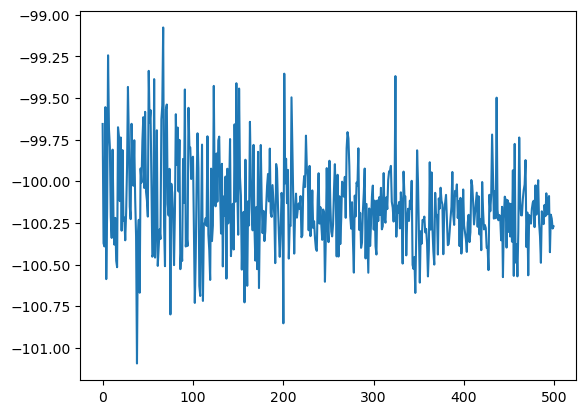

In [38]:
plt.plot(epochs, energy_data)
plt.show()

In [39]:
20 * lib.ground_state_energy_per_site(1, 20)

np.float64(-25.49098968636475)